# Task 3 - Implementation of ANN

In [1]:
from helpers.models.utils import get_learn_test, bootstrap_and_split
from helpers.plots import plot_2d_tuning_plot, simple_histogram
from helpers.ann import get_nn

In [2]:
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error

### 1. Load and prepare the dataset

In [3]:
X_learn, X_test, y_learn, y_test = get_learn_test()


In [4]:
print(X_learn.shape)
print(X_test.shape)

(59568, 21)
(14893, 21)


### 2. Define model

In [5]:
# define parameters
K = 10
hidden_layer_params = [[1], [2], [3], [4, 2], [5, 2], [5, 3], [6, 3], [10, 4], [12, 5]]


In [6]:
# define specific configuration to show ANN architecture
MODEL_NUMBER = 2
hidden = hidden_layer_params[MODEL_NUMBER]
print(hidden)


[3]


In [8]:
# define and compile model with given configuration
model = get_nn(K, hidden)
model.summary()

Model: "ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 66        
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


### 3. Visualise model

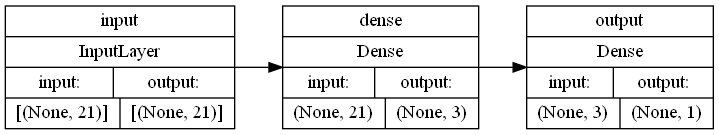

In [9]:
# visualization with graphviz
dot_img_file = "model_vis/model_" + str(MODEL_NUMBER) + ".png"
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir="LR")


### 4. Train model

Prepare bootstrapping and k-fold cross validation. Randomly sample 1000 data points 50 times.

In [10]:
# define parameters
batch_size = 1

N_BOOTSTRAPS = 50
N_SAMPLES_PER_BOOTSTRAP = 2000
SPLIT_PER_BOOTSTRAP = 0.5
MAX_PATIENCE = 10


In [11]:
# Early stopping
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=MAX_PATIENCE, verbose=1)]


Fit the model with all model configurations with 50 bootstrapped sets. 

In [12]:
results_dict = {}

for num_model, hidden in enumerate(hidden_layer_params):
    mse_train = []
    mse_val = []
    print("For model: " + str(hidden))

    for i in range(N_BOOTSTRAPS):
        model = get_nn(K, hidden)

        X_train, X_val, y_train, y_val = bootstrap_and_split(
            X_learn, y_learn, n_samples=N_SAMPLES_PER_BOOTSTRAP, test_size=SPLIT_PER_BOOTSTRAP
        )

        model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=100,
            callbacks=callbacks,
            validation_data=(X_val, y_val),
            verbose=0,
        )
        mse_train_loss = mean_squared_error(y_train, model.predict(X_train))
        mse_val_loss = mean_squared_error(y_val, model.predict(X_val))
        mse_train.append(mse_train_loss)
        mse_val.append(mse_val_loss)
        print("mse_train: " + str(format(mse_train_loss, ".4f")) + ", mse_val: " + str(format(mse_val_loss, ".4f")))

    results_dict[num_model] = {"mse_train": mse_train, "mse_val": mse_val}


For model: [1]
Epoch 00065: early stopping
mse_train: 0.0389, mse_val: 0.0473
Epoch 00091: early stopping
mse_train: 0.0427, mse_val: 0.0411
Epoch 00049: early stopping
mse_train: 0.0411, mse_val: 0.0439
Epoch 00064: early stopping
mse_train: 0.0433, mse_val: 0.0427
Epoch 00057: early stopping
mse_train: 0.0410, mse_val: 0.0459
Epoch 00074: early stopping
mse_train: 0.0402, mse_val: 0.0435
Epoch 00079: early stopping
mse_train: 0.0454, mse_val: 0.0408
Epoch 00074: early stopping
mse_train: 0.0440, mse_val: 0.0473
Epoch 00055: early stopping
mse_train: 0.0422, mse_val: 0.0452
Epoch 00077: early stopping
mse_train: 0.0393, mse_val: 0.0431
Epoch 00071: early stopping
mse_train: 0.0431, mse_val: 0.0447
Epoch 00066: early stopping
mse_train: 0.0442, mse_val: 0.0521
Epoch 00058: early stopping
mse_train: 0.0444, mse_val: 0.0487
Epoch 00071: early stopping
mse_train: 0.0398, mse_val: 0.0420
Epoch 00047: early stopping
mse_train: 0.0455, mse_val: 0.0444
Epoch 00084: early stopping
mse_train: 0

In [13]:
# prepare data for visualisation of mean and variance of mse train and val for all model configurations
for setting, results in results_dict.items():
    results_dict[setting]["mse_train_mean"] = np.mean(results["mse_train"])
    results_dict[setting]["mse_val_mean"] = np.mean(results["mse_val"])
    results_dict[setting]["mse_train_std"] = np.std(results["mse_train"])
    results_dict[setting]["mse_val_std"] = np.std(results["mse_val"])
results_df = pd.DataFrame.from_dict(results_dict, orient="index")


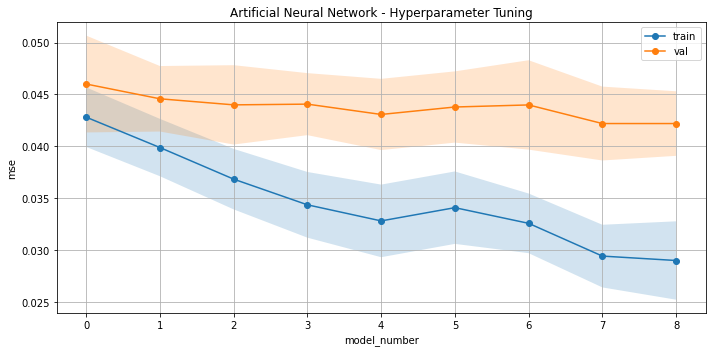

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_2d_tuning_plot(
    name_hyperparameter="model_number",
    name_metric="mse",
    name_model="Artificial Neural Network",
    hyperparams=results_df.index,
    mean_score_train=results_df["mse_train_mean"],
    mean_score_val=results_df["mse_val_mean"],
    std_score_train=results_df["mse_train_std"],
    std_score_val=results_df["mse_val_std"],
    ax=ax,
    marker="o",
)
fig.tight_layout()


### 5. Train with the best model on whole learn dataset

In [35]:
num_best_model = results_df["mse_val_mean"].argmin()
print(hidden_layer_params[num_best_model])


[12, 5]


In [12]:
model = get_nn(K, hidden_layer_params[num_best_model])
history = model.fit(X_learn, y_learn, batch_size=batch_size, epochs=50, validation_split=0.2, callbacks=callbacks)


Epoch 1/50
47654/47654 [==============================] - 50s 1ms/step - loss: 0.0480 - val_loss: 0.0396
Epoch 2/50
47654/47654 [==============================] - 48s 1ms/step - loss: 0.0360 - val_loss: 0.0360
Epoch 3/50
47654/47654 [==============================] - 43s 908us/step - loss: 0.0336 - val_loss: 0.0326
Epoch 4/50
47654/47654 [==============================] - 43s 910us/step - loss: 0.0321 - val_loss: 0.0362
Epoch 5/50
47654/47654 [==============================] - 43s 909us/step - loss: 0.0307 - val_loss: 0.0307
Epoch 6/50
47654/47654 [==============================] - 43s 903us/step - loss: 0.0293 - val_loss: 0.0292
Epoch 7/50
47654/47654 [==============================] - 43s 903us/step - loss: 0.0283 - val_loss: 0.0281
Epoch 8/50
47654/47654 [==============================] - 43s 910us/step - loss: 0.0276 - val_loss: 0.0277
Epoch 9/50
47654/47654 [==============================] - 43s 909us/step - loss: 0.0271 - val_loss: 0.0277
Epoch 10/50
47654/47654 [================

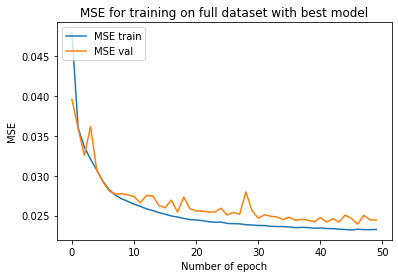

In [13]:
plt.plot(history.history["loss"], label="MSE train")
plt.plot(history.history["val_loss"], label="MSE val")
plt.title("MSE for training on full dataset with best model")
plt.ylabel("MSE")
plt.xlabel("Number of epoch")
plt.legend(loc="upper left")
plt.show()


In [32]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=batch_size)
print("test loss:", results)


Evaluate on test data
14893/14893 [==============================] - 10s 644us/step - loss: 0.0251
test loss: 0.025135064497590065


### 6. Compare ANN with Random Forests

Compare results of ANN with Random Forests

In [14]:
import os

# load results from random forests
random_forest_preds = pickle.load(open(os.path.join("out", "task_4_rf_pred_test.pkl"), "rb"))
random_forest_errors = random_forest_preds - y_test
print(random_forest_errors.shape)


(14893,)


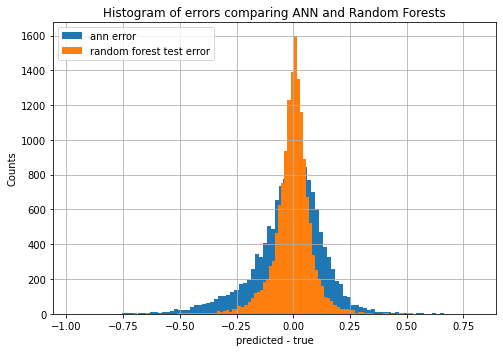

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))
nn_abs_error = model.predict(X_test).squeeze() - y_test
num_bins = 100
simple_histogram(
    nn_abs_error,
    title="Histogram of errors comparing ANN and Random Forests",
    xlabel="predicted - true",
    legend_label="ann error",
    num_bins=num_bins,
    ax=ax,
)

fig.tight_layout()
ax.hist(random_forest_errors, num_bins, label="random forest test error")
ax.legend(loc="upper left")
